<a href="https://colab.research.google.com/github/AlisonZa/langgraph-dataframe-copilot/blob/main/LangGraph_DataFrame_Copilot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## LangGraph DataFrame Copilot

### Setup

In [2]:
!pip install dotenv
!pip install langchain
!pip install langgraph
!pip install typing
!pip install langchain_experimental
!pip install langchain_groq

from google.colab import userdata
from IPython.display import Image
from langgraph.graph import END, StateGraph, START

import os
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage
import pandas as pd
from langchain_experimental.tools import PythonAstREPLTool
import matplotlib.pyplot as plt
from pydantic import BaseModel, Field, Json
from langchain_groq import ChatGroq
plt.show(block=False) # make it able to show plots
from typing import List, Optional, Literal
import numpy as np
from typing import Annotated, Literal
import pandas as pd

os.environ['LANGCHAIN_API_KEY'] = userdata.get('LANGCHAIN_API_KEY')
os.environ['GROQ_API_KEY'] = userdata.get('GROQ_API_KEY')


  Using cached dotenv-0.0.5.tar.gz (2.4 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [3]:
df = pd.read_csv('https://gist.githubusercontent.com/kevin336/acbb2271e66c10a5b73aacf82ca82784/raw/e38afe62e088394d61ed30884dd50a6826eee0a8/employees.csv')

model = ChatGroq(temperature=0, model = 'llama3-groq-70b-8192-tool-use-preview')
python_ast_repl = PythonAstREPLTool(locals={"df": df})

### Utils

In [4]:
def get_data_frame_info(df):
    """Gets the dataframe collumns names and types, for prompting purposes"""
    import io
    # Create a buffer to capture the output
    buffer = io.StringIO()
    # Write the info into the buffer instead of printing it
    df.info(verbose=True, buf=buffer, max_cols=None, memory_usage=False, show_counts=None)
    # Get the value from the buffer
    df_info = buffer.getvalue()
    # Close the buffer
    buffer.close()
    return df_info

df_info = get_data_frame_info(df)


### Prompts

In [5]:
analyst_system_prompt = """
You are a data analyst that provide python code to help in a data analysis projects.
You are going to help to analyse a dataframe named 'df' that has the following collumns:
###################
{df_info}
###################
You output code that is going to be provided to an code executor.
The dataframe variable name is 'df', make sure to include that in the code.
"""
analyst_human_prompt = """
Your code should answer to the following user query: \n
###################
Query:
{user_query}
"""

feedbackrouter_system_prompt = """
You are going to receive the user feedback, of some code generated to analyse a pandas dataframe.
This is the feedback:
##################
{human_feedback}
"""

regenerate_code_system_prompt = """
You are a data analyst that provide python code to help in a data analysis projects.
You are going to help to analyse a dataframe named 'df' that has the following collumns:
###################
{df_info}
###################
You output code that is going to be provided to a code executor.
The dataframe variable name is 'df', make sure to include that in the code.
If there is a user_feedback make sure to pay attention to it.
"""

regenerate_code_human_prompt = """
Your code should answer to the following user query: \n
###################
Query:\n
{user_query}
##################
In the past you gave the following code:
#################
Code: \n
{past_code}

#################
The user provided you the following feedback to the past code execution:
#################
User feedback:
{user_feedback}
#################
Create a new code, so the user feed is respected.
"""


### Nodes/Graph

In [6]:
# Oversall State
class AnalystState(BaseModel):
    user_query: str = Field(description= "User query that the agent must run")
    code: Optional[str] = Field(None, description="Python Code to run")
    feedback: Optional[str] = Field(None, description="Feedback provided by the user")
    is_feedback: Literal["no", "yes"] = Field("no", description="If there is feedback then:'yes', else:'no'")

# Class to be passed as structure output
class CodeExecutorState(BaseModel):
    code: str = Field(description="Python Code to run")

# Class to be passed as structure output
class HumanFeedback(BaseModel):
    feedback: str = Field(description="Feedback provided by the user")
    is_feedback: Literal["no", "yes"] = Field(description=" if there is something to improve in the code")


def generate_code(state: AnalystState):
    print(f"{'*'*10}User Query:{'*'*10}\n{state.user_query}")

    messages = [
    (SystemMessage(content=analyst_system_prompt.format(df_info = df_info))),
    (HumanMessage(content = analyst_human_prompt.format(user_query = state.user_query)))]
    response = model.with_structured_output(CodeExecutorState).invoke(messages)

    print(f"{'*'*10}Code to solve the query:{'*'*10}\n{response.code}")
    return {"code": response.code}

def execute_code(state: AnalystState):
    python_ast_repl = PythonAstREPLTool(locals={"df": df})
    result = python_ast_repl(state.code)
    print(result)

def receive_feedback(state: AnalystState):
    feedback = input(f"Do you want to change something in the code?")

    messages = [
    (SystemMessage(content=feedbackrouter_system_prompt.format(human_feedback = feedback))),]
    response = model.with_structured_output(HumanFeedback).invoke(messages)

    print(f"{'*'*20}")
    print(f"feedback\n:{response.feedback}, is_feedback\n:{response.is_feedback}")

    return {"feedback": response.feedback, "is_feedback": response.is_feedback}

def should_continue(state:AnalystState)-> Literal['end','regenerate_code']:
    if state.is_feedback == "no":
        return "end"
    else:
        return "regenerate_code"

def regenerate_code(state: AnalystState):
    print(f"User Query:{state.user_query}")

    messages = [
    (SystemMessage(content=regenerate_code_system_prompt.format(df_info = df_info))),
    (HumanMessage(content = regenerate_code_human_prompt.format(
        user_query = state.user_query, past_code = state.code, user_feedback = state.feedback)))]

    print(f"{state.feedback} ")
    response = model.with_structured_output(CodeExecutorState).invoke(messages)

    print(f"{'*'*10}Code to solve the query and the user feedback:{'*'*10}\n{response.code}")
    return {"code": response.code}


<ipython-input-7-4a5a69e753e2>:3: LangGraphDeprecationWarning: Initializing StateGraph without state_schema is deprecated. Please pass in an explicit state_schema instead of just an input and output schema.
  builder = StateGraph(input=AnalystState, output=AnalystState)


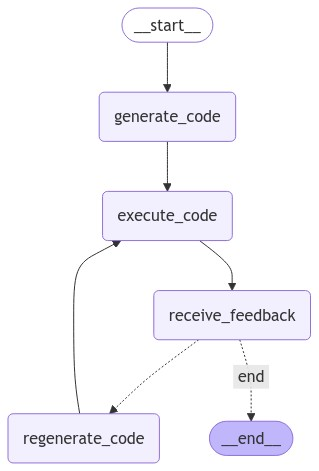

In [7]:
# Build graph

builder = StateGraph(input=AnalystState, output=AnalystState)
builder.add_node("generate_code", generate_code)
builder.add_node("execute_code", execute_code)
builder.add_node("receive_feedback", receive_feedback)
builder.add_node("regenerate_code", regenerate_code)

# Logic
builder.add_edge(START, "generate_code")
builder.add_edge("generate_code", "execute_code")
builder.add_edge("execute_code", "receive_feedback")
# We now add a conditional edge
builder.add_conditional_edges(
    "receive_feedback",# node from wich the edge comes
    should_continue,#Function
    {
        # If should_continue outputs regenerate_code, we regenerate_code, else we end the graph
        "regenerate_code": "regenerate_code",
        # Otherwise we finish.
        "end": END,
    },
)
builder.add_edge("regenerate_code", "execute_code")

# Compile
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

### Examples

**********User Query:**********
Plot me a chart of the salary by Manager
**********Code to solve the query:**********
import matplotlib.pyplot as plt

# Group the data by 'MANAGER_ID' and calculate the mean 'SALARY'
mean_salaries = df.groupby('MANAGER_ID')['SALARY'].mean().reset_index()
mean_salaries.columns = ['MANAGER_ID', 'Mean_Salary']

# Plot the data
plt.figure(figsize=(10, 6))
plt.bar(mean_salaries['MANAGER_ID'], mean_salaries['Mean_Salary'], color='skyblue')
plt.xlabel('Manager ID')
plt.ylabel('Mean Salary')
plt.title('Mean Salary by Manager')
plt.show()


<ipython-input-6-3f1eeb02bb36>:27: LangChainDeprecationWarning: The method `BaseTool.__call__` was deprecated in langchain-core 0.1.47 and will be removed in 1.0. Use :meth:`~invoke` instead.
  result = python_ast_repl(state.code)


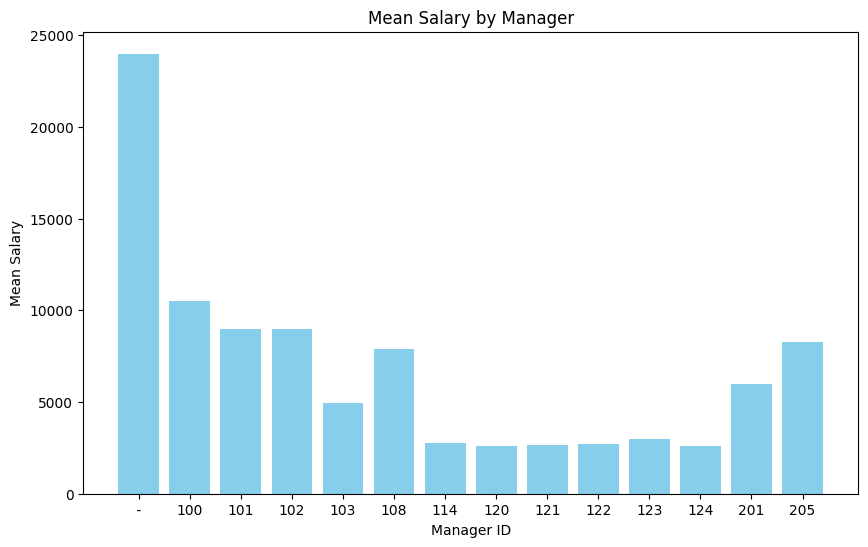


Do you want to change something in the code?Yes, change the color to red
********************
feedback
:Yes, change the color to red, is_feedback
:yes
User Query:Plot me a chart of the salary by Manager
Yes, change the color to red 
**********Code to solve the query and the user feedback:**********
import matplotlib.pyplot as plt

# Group the data by 'MANAGER_ID' and calculate the mean 'SALARY'
mean_salaries = df.groupby('MANAGER_ID')['SALARY'].mean().reset_index()
mean_salaries.columns = ['MANAGER_ID', 'Mean_Salary']

# Plot the data
plt.figure(figsize=(10, 6))
plt.bar(mean_salaries['MANAGER_ID'], mean_salaries['Mean_Salary'], color='red')
plt.xlabel('Manager ID')
plt.ylabel('Mean Salary')
plt.title('Mean Salary by Manager')
plt.show()


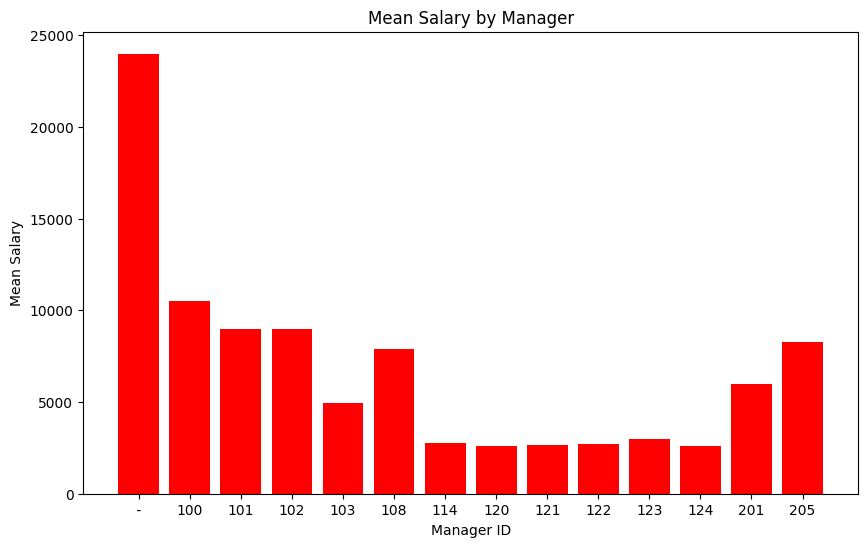


Do you want to change something in the code?rotate the xticks and change the title of the plot to Mean salary by Manager ID
********************
feedback
:rotate the xticks and change the title of the plot to Mean salary by Manager ID, is_feedback
:yes
User Query:Plot me a chart of the salary by Manager
rotate the xticks and change the title of the plot to Mean salary by Manager ID 
**********Code to solve the query and the user feedback:**********
import matplotlib.pyplot as plt

# Group the data by 'MANAGER_ID' and calculate the mean 'SALARY'
mean_salaries = df.groupby('MANAGER_ID')['SALARY'].mean().reset_index()
mean_salaries.columns = ['MANAGER_ID', 'Mean_Salary']

# Plot the data
plt.figure(figsize=(10, 6))
plt.bar(mean_salaries['MANAGER_ID'], mean_salaries['Mean_Salary'], color='red')
plt.xlabel('Manager ID')
plt.ylabel('Mean Salary')
plt.title('Mean salary by Manager ID')
plt.xticks(rotation=45)
plt.show()


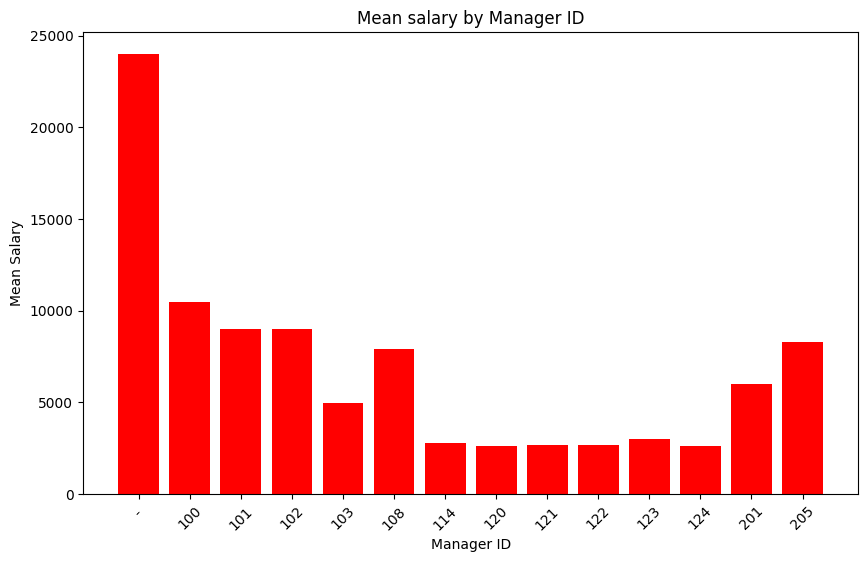


Do you want to change something in the code?Create a new plot, now containing the max salary
********************
feedback
:Create a new plot, now containing the max salary, is_feedback
:yes
User Query:Plot me a chart of the salary by Manager
Create a new plot, now containing the max salary 
**********Code to solve the query and the user feedback:**********
import matplotlib.pyplot as plt

# Group the data by 'MANAGER_ID' and calculate the mean 'SALARY'
mean_salaries = df.groupby('MANAGER_ID')['SALARY'].mean().reset_index()
mean_salaries.columns = ['MANAGER_ID', 'Mean_Salary']

# Group the data by 'MANAGER_ID' and calculate the max 'SALARY'
max_salaries = df.groupby('MANAGER_ID')['SALARY'].max().reset_index()
max_salaries.columns = ['MANAGER_ID', 'Max_Salary']

# Merge the two dataframes
merged_data = mean_salaries.merge(max_salaries, on='MANAGER_ID')

# Plot the data
plt.figure(figsize=(10, 6))
plt.bar(merged_data['MANAGER_ID'], merged_data['Mean_Salary'], color='red', label='Mean Sa

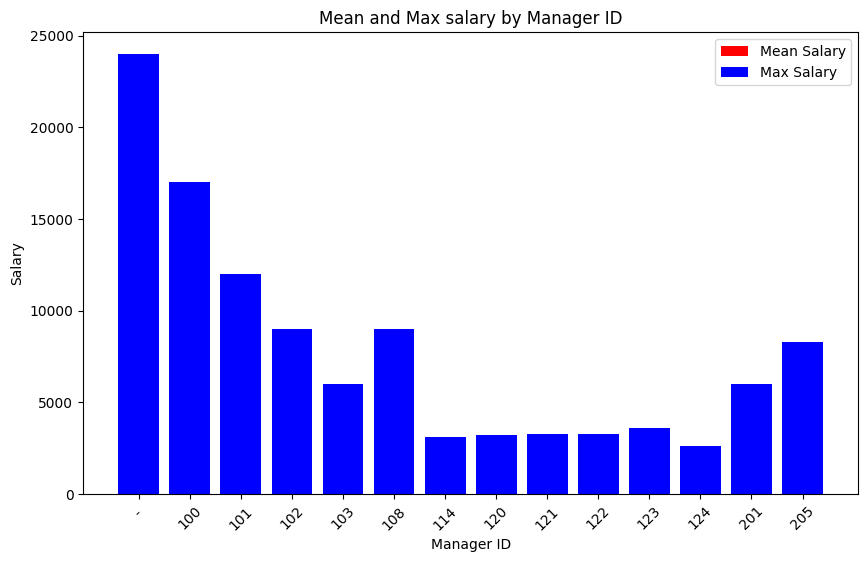


Do you want to change something in the code?I cant see the mean salary anymore
********************
feedback
:I cant see the mean salary anymore, is_feedback
:yes
User Query:Plot me a chart of the salary by Manager
I cant see the mean salary anymore 
**********Code to solve the query and the user feedback:**********
import matplotlib.pyplot as plt

# Group the data by 'MANAGER_ID' and calculate the mean 'SALARY'
mean_salaries = df.groupby('MANAGER_ID')['SALARY'].mean().reset_index()
mean_salaries.columns = ['MANAGER_ID', 'Mean_Salary']

# Group the data by 'MANAGER_ID' and calculate the max 'SALARY'
max_salaries = df.groupby('MANAGER_ID')['SALARY'].max().reset_index()
max_salaries.columns = ['MANAGER_ID', 'Max_Salary']

# Merge the two dataframes
merged_data = mean_salaries.merge(max_salaries, on='MANAGER_ID')

# Plot the data
plt.figure(figsize=(10, 6))
plt.bar(merged_data['MANAGER_ID'], merged_data['Mean_Salary'], color='red', label='Mean Salary')
plt.bar(merged_data['MANAGER_ID'], 

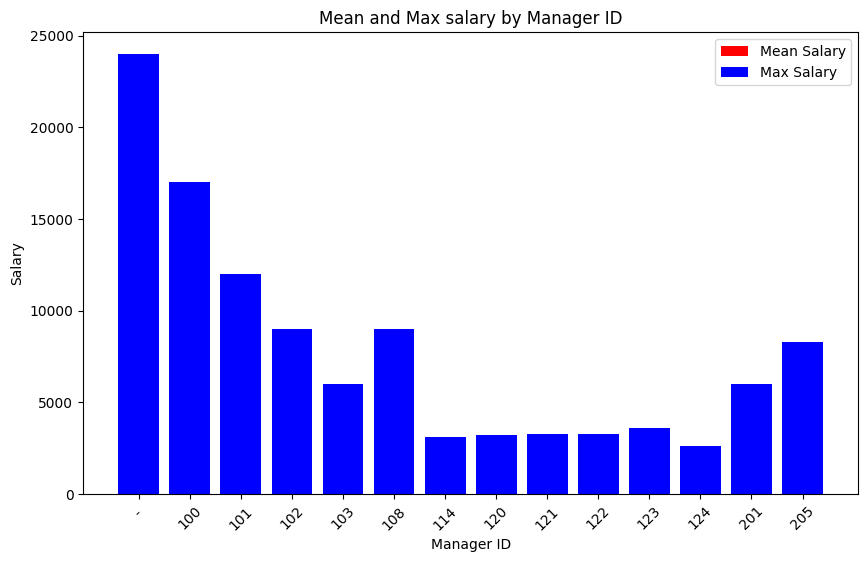


Do you want to change something in the code?Put the mean salary as a line chart in this plt
********************
feedback
:Put the mean salary as a line chart in this plt, is_feedback
:yes
User Query:Plot me a chart of the salary by Manager
Put the mean salary as a line chart in this plt 
**********Code to solve the query and the user feedback:**********
import matplotlib.pyplot as plt

# Group the data by 'MANAGER_ID' and calculate the mean 'SALARY'
mean_salaries = df.groupby('MANAGER_ID')['SALARY'].mean().reset_index()
mean_salaries.columns = ['MANAGER_ID', 'Mean_Salary']

# Group the data by 'MANAGER_ID' and calculate the max 'SALARY'
max_salaries = df.groupby('MANAGER_ID')['SALARY'].max().reset_index()
max_salaries.columns = ['MANAGER_ID', 'Max_Salary']

# Merge the two dataframes
merged_data = mean_salaries.merge(max_salaries, on='MANAGER_ID')

# Plot the data
plt.figure(figsize=(10, 6))
plt.bar(merged_data['MANAGER_ID'], merged_data['Max_Salary'], color='blue', label='Max Salary

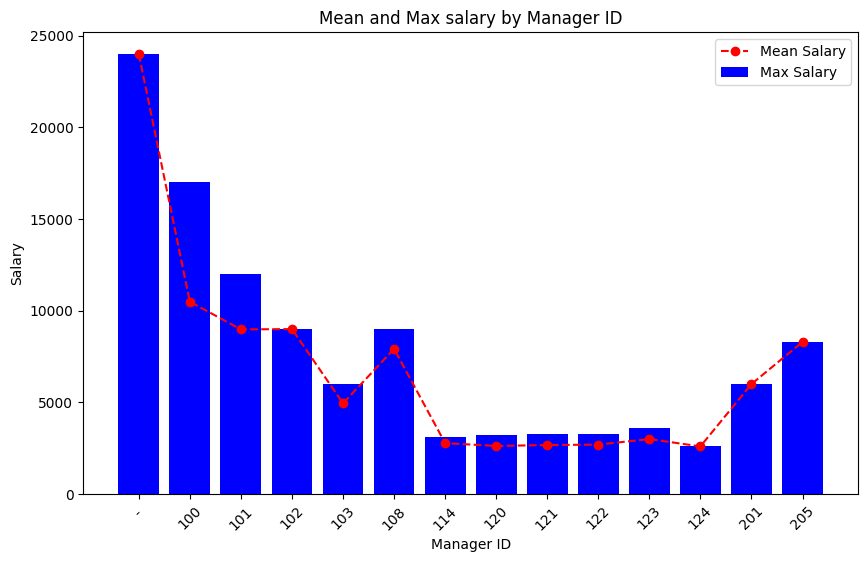


Do you want to change something in the code?Thanks, the code is fine now, no feedback
********************
feedback
:Thanks, the code is fine now, no feedback, is_feedback
:no


In [8]:
# Invoke the graph
output = graph.invoke({"user_query": "Plot me a chart of the salary by Manager"})

**********User Query:**********
What are the top 15 Salaries?
**********Code to solve the query:**********
df.nlargest(15, 'SALARY')
    EMPLOYEE_ID FIRST_NAME  LAST_NAME     EMAIL  PHONE_NUMBER  HIRE_DATE  \
9           100     Steven       King     SKING  515.123.4567  17-JUN-03   
10          101      Neena    Kochhar  NKOCHHAR  515.123.4568  21-SEP-05   
11          102        Lex    De Haan   LDEHAAN  515.123.4569  13-JAN-01   
3           201    Michael  Hartstein  MHARTSTE  515.123.5555  17-FEB-04   
7           205    Shelley    Higgins  SHIGGINS  515.123.8080  07-JUN-02   
17          108      Nancy  Greenberg  NGREENBE  515.124.4569  17-AUG-02   
23          114        Den   Raphaely  DRAPHEAL  515.127.4561  07-DEC-02   
6           204    Hermann       Baer     HBAER  515.123.8888  07-JUN-02   
12          103  Alexander     Hunold   AHUNOLD  590.423.4567  03-JAN-06   
18          109     Daniel     Faviet   DFAVIET  515.124.4169  16-AUG-02   
8           206    William     

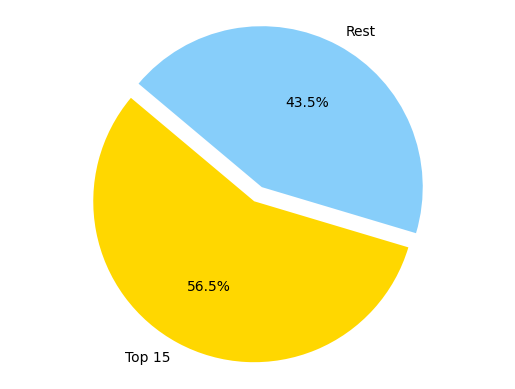

**********Code to solve the query and the user feedback:**********
import matplotlib.pyplot as plt

# Calculate the sum of the top 15 salaries
sum_top_15 = df.nlargest(15, 'SALARY')['SALARY'].sum()

# Calculate the sum of the rest of the salaries
sum_rest = df.nsmallest(35, 'SALARY')['SALARY'].sum()

# Create a pie chart comparing the sum of the top 15 to the rest
labels = ['Top 15', 'Rest']
sizes = [sum_top_15, sum_rest]
colors = ['gold', 'lightskyblue']
explode = (0.1, 0)  # explode 1st slice
autopct = '%1.1f%%'  # string formatting code to use when adding percentages
shadow = False
startangle = 140

plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct=autopct, shadow=shadow, startangle=startangle)
plt.axis('equal')
plt.show()

Do you want to change something in the code?Insert a Title: Top 15 Salary Employees Comparisson, and change the colors
********************
feedback
:Insert a Title: Top 15 Salary Employees Comparisson, and change the colors, is_feedba

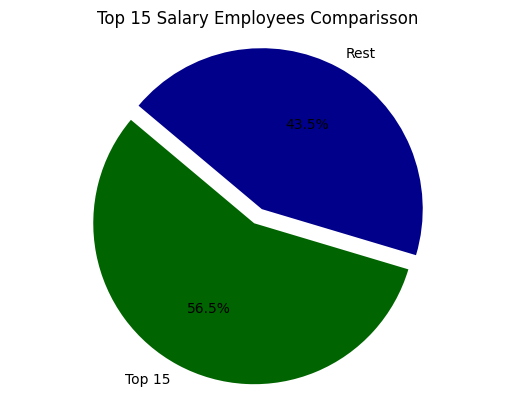

**********Code to solve the query and the user feedback:**********
import matplotlib.pyplot as plt

# Calculate the sum of the top 15 salaries
sum_top_15 = df.nlargest(15, 'SALARY')['SALARY'].sum()

# Calculate the sum of the rest of the salaries
sum_rest = df.nsmallest(35, 'SALARY')['SALARY'].sum()

# Create a pie chart comparing the sum of the top 15 to the rest
labels = ['Top 15', 'Rest']
sizes = [sum_top_15, sum_rest]
colors = ['darkgreen', 'darkblue']
explode = (0.1, 0)  # explode 1st slice
autopct = '%1.1f%%'  # string formatting code to use when adding percentages
shadow = False
startangle = 140

plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct=autopct, shadow=shadow, startangle=startangle)
plt.axis('equal')
plt.title('Top 15 Salary Employees Comparisson')
plt.show()

Do you want to change something in the code?Change the colors to red and blue
********************
feedback
:Change the colors to red and blue, is_feedback
:yes
User Query:What are the 

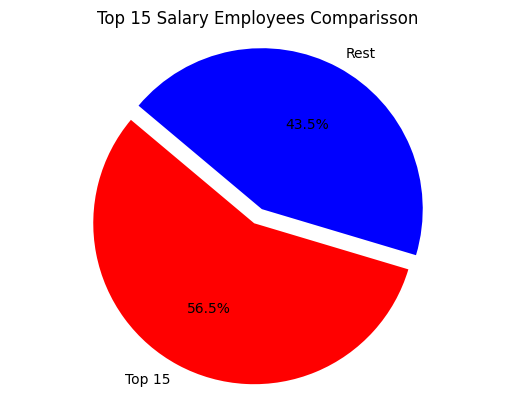

**********Code to solve the query and the user feedback:**********
import matplotlib.pyplot as plt

# Calculate the sum of the top 15 salaries
sum_top_15 = df.nlargest(15, 'SALARY')['SALARY'].sum()

# Calculate the sum of the rest of the salaries
sum_rest = df.nsmallest(35, 'SALARY')['SALARY'].sum()

# Create a pie chart comparing the sum of the top 15 to the rest
labels = ['Top 15', 'Rest']
sizes = [sum_top_15, sum_rest]
colors = ['red', 'blue']
explode = (0.1, 0)  # explode 1st slice
autopct = '%1.1f%%'  # string formatting code to use when adding percentages
shadow = False
startangle = 140

plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct=autopct, shadow=shadow, startangle=startangle)
plt.axis('equal')
plt.title('Top 15 Salary Employees Comparisson')
plt.show()

Do you want to change something in the code?Great, Thanks
********************
feedback
:Great, Thanks, is_feedback
:no


In [11]:
output = graph.invoke({"user_query": "What are the top 15 Salaries?"})